O código a seguir já foi introduzido nos notebooks anteriores.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  #Definição da operação de soma
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    #Como visto anteriormente, a derivada de uma soma é 1. Logo, com a regra da cadeia, basta fazer um "repasse" do gradiente que está "chegando"
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  #Definição da operação de multiplicação
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    #Como visto anteriormente, a derivada de uma multiplicação é o "outro termo". Logo, com a regra da cadeia, basta fazer uma multiplicação entre o "outro termo" e o grandiente que está "chegando"
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  #Definição da operação de potenciação
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    #Como visto anteriormente, de acordo com a Regra do Tombo, a derivada de A^b deve ser b*A^b-1. Logo, com a regra da cadeia, basta multiplicar o resultado com o gradiente que está "chegando" 
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  #Definição da operação de multiplicação com a inversão dos fatores
  def __rmul__(self, other):
    return self * other

  #Definição da operação de divisão como uma operação de potenciação
  def __truediv__(self, other):
    return self * other**-1

  #Definição da operação do negativo de um valor
  def __neg__(self):
    return self * -1
  
  #Definição da operação de subtração
  def __sub__(self, other):
    return self + (-other)

  #Definição da operação de adição com a inversão dos valores
  def __radd__(self, other):
    return self + other

  #Definição da função Tangente Hiperbólica
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    #Cálculo do gradiente com base na derivada da função e, com a regra da cadeia, no gradiente que está "chegando"
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  #Definição da função de exponencial natural
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    #Como visto anteriormente, a derivada dessa função é ela mesma, por isso, basta multiplicar o seu valor pelo gradiente que está "chegando"
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  #Função que orquestra o cálculo dos gradientes
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

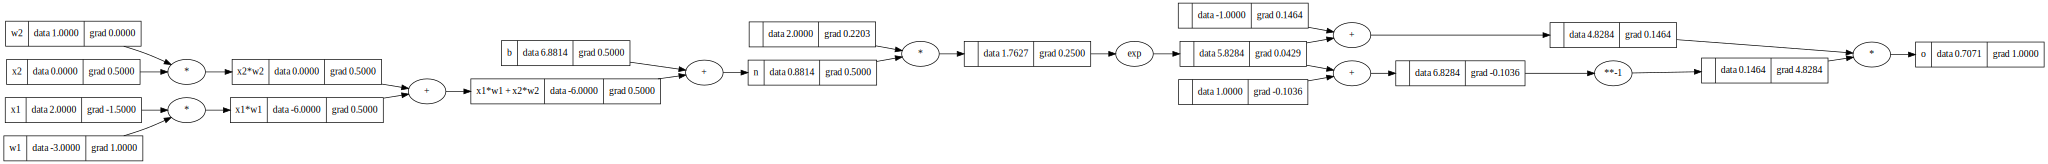

In [3]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# A seguir a função tanh foi desmenbrada, a fim de aparecer mais explicitamente no grafo
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [5]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.backward()

print()
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())


x2: 0.5000001283844369
w2: 0.0
x1: -1.5000003851533106
w1: 1.0000002567688737


Acima nós utilizamos de uma biblioteca chamada de **PyTorch**, a fim de conferir se o cálculo dos gradientes batem, o que acontece.

Essa é uma biblioteca que é recorrentemente utilizada para a aplicação de ténicas e arquiteturas de Machine Learning e, por isso, já conta com diversas funções que automatizam todo o processo realizado nesse repositório.